In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

import TensorFlow
import Python

let subprocess = Python.import("subprocess")
let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")

let IMAGENETTE_URL = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette.tgz"
let IMAGENETTE_160_URL = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160.tgz"
let IMAGENETTE_320_URL = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette-320.tgz"
let IMAGENETTE_FILE = "imagenette.tgz"

In [ ]:
// First let us download the dataset. 
func downloadImagenetteData(_ url: String, _ filename: String) -> String {
    let urllib = Python.import("urllib.request")
    let downloadResult = urllib.urlretrieve(url, filename)
    print("\(downloadResult[0])")
    return String(downloadResult[0])!
}

//downloadImagenetteData(IMAGENETTE_160_URL, IMAGENETTE_FILE)
subprocess.run(["wget", IMAGENETTE_160_URL])
subprocess.run(["tar", "-xzvf", "imagenette-160.tgz"])
subprocess.run(["ls"])

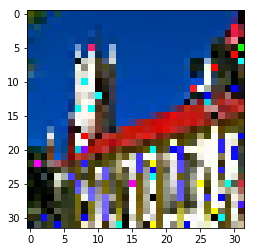

None


In [ ]:
func resizeImage(filename: StringTensor) -> Tensor<UInt8> {
    let imageBytes: StringTensor = Raw.readFile(filename: filename)
    let decodedImage = Raw.decodeJpeg(contents: imageBytes, channels: 3, dctMethod: "") 
    let resizedImages = Raw.resizeBicubic(
        images: Tensor<UInt8>([decodedImage]), 
        size: Tensor<Int32>([32, 32]))
    let resizedImage = resizedImages.reshaped(to: TensorShape(32, 32, 3))
    return Raw.cast(resizedImage)
}

let resizedImage = resizeImage(filename: StringTensor("imagenette-160/val/n03028079/ILSVRC2012_val_00003682.JPEG"))
let npa = resizedImage.makeNumpyArray()
plt.imshow(npa) //npa.shape
plt.show()


In [ ]:
let filenames = StringTensor([
    "imagenette-160/val/n03028079/ILSVRC2012_val_00034021.JPEG",
    "imagenette-160/val/n03028079/ILSVRC2012_val_00026451.JPEG",
    "imagenette-160/val/n03028079/ILSVRC2012_val_00006268.JPEG",
    "imagenette-160/val/n03028079/ILSVRC2012_val_00004912.JPEG",
    "imagenette-160/val/n03028079/ILSVRC2012_val_00009705.JPEG",
    "imagenette-160/val/n03028079/ILSVRC2012_val_00017783.JPEG",
    "imagenette-160/val/n03028079/ILSVRC2012_val_00033509.JPEG",
    "imagenette-160/val/n03028079/ILSVRC2012_val_00046232.JPEG",
    "imagenette-160/val/n03028079/ILSVRC2012_val_00019331.JPEG",
    "imagenette-160/val/n03028079/ILSVRC2012_val_00005295.JPEG",
    "imagenette-160/val/n03028079/ILSVRC2012_val_00048853.JPEG",
    "imagenette-160/val/n03028079/ILSVRC2012_val_00035753.JPEG",
    "imagenette-160/val/n03028079/ILSVRC2012_val_00004939.JPEG",
    "imagenette-160/val/n03028079/ILSVRC2012_val_00008116.JPEG",
    "imagenette-160/val/n03028079/ILSVRC2012_val_00034220.JPEG"])


Processing image 0
Processing image 1
Processing image 2
Processing image 3


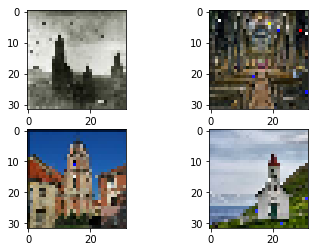

None


In [ ]:
let ds:Dataset<Tensor<UInt8>> = Dataset<StringTensor>(elements: filenames).map(resizeImage)
//.batched(5) // For batching

let rows = 2 
let cols = 2 
//plt.figure(figsize: [rows * 3, cols * 3])

for (i, d) in ds.enumerated() {
    print("Processing image \(i)")
    let img = plt.subplot(rows, cols, i + 1)
    img.imshow(d.makeNumpyArray())
    if (i + 1) >= (rows * cols) { break }
}
plt.show()
